In [161]:
# GET LIBRARIES
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


In [162]:
# MAIN FUNCTIONS

def load_suite2p_outputs(base_directory, plane="plane0"):
    """Discover and load Suite2p outputs for every session under a subject-level directory."""
    file_dict = {
        'roi_fluorescence': '*F.npy',
        'neuropil_fluorescence': '*Fneu.npy',
        'cell_identifier': '*iscell.npy',
        'intermediate_outputs': '*ops.npy',
        'roi_traces': '*spks.npy',
        'roi_statistics': '*stat.npy'
    }
    base_path = Path(base_directory)
    if not base_path.exists():
        raise FileNotFoundError(f"Base directory not found: {base_directory}")
    subject_id = next((part for part in base_path.parts if part.startswith('sub-')), base_path.name)
    task_label = base_path.name
    session_plane_paths = sorted(base_path.glob(f"ses-*/suite2p/{plane}"))
    if not session_plane_paths:
        raise FileNotFoundError(f"No sessions with {plane} found under {base_directory}")
    loaded_sessions = {}
    for plane_path in session_plane_paths:
        session_id = plane_path.parent.parent.name  # plane0 -> suite2p -> ses-*
        session_key = f"{subject_id}_{session_id}"
        print(f"Found Suite2p folder for {session_key} (task={task_label}): {plane_path}")
        session_data = {}
        for key, pattern in file_dict.items():
            matched_files = sorted(plane_path.glob(pattern))
            if not matched_files:
                raise FileNotFoundError(f"Missing file matching {pattern} in {plane_path}")
            session_data[key] = np.load(matched_files[0], allow_pickle=True)
        session_data['task_label'] = task_label
        loaded_sessions[session_key] = session_data
    return loaded_sessions

def load_all_suite2p_outputs(data_root, subject_ids, plane="plane0", task="mov"):
    """Load Suite2p outputs for every requested subject and session for a specific task."""
    data_root = Path(data_root)
    task_label = task if isinstance(task, str) else str(task)
    combined_sessions = {}
    subject_session_index = {}
    for subject in subject_ids:
        subject_label = normalise_subject_id(subject)
        subject_dir = data_root / subject_label / task_label
        if not subject_dir.exists():
            raise FileNotFoundError(f"Subject directory for task not found: {subject_dir}")
        print(f"Scanning Suite2p outputs for {subject_label} (task={task_label}) in {subject_dir}")
        subject_sessions = load_suite2p_outputs(subject_dir, plane=plane)
        combined_sessions.update(subject_sessions)
        subject_session_index[subject_label] = sorted(
        [key.split("_", 1)[1] for key in subject_sessions]
        )
    return combined_sessions, subject_session_index


def calculate_dff(raw, baseline):  # this will calculate the dff values for each roi
    dff_list = []
    for row in range(len(raw)):
        dff = ((raw[row] - baseline[row])/(baseline[row]))
        dff_list.append(dff)
    return dff_list

def calculate_baseline(raw_fluorescence, percentile):  # this will calculate the specified percentile along each roi's raw fluorescence
    percentile_list = []
    for row in raw_fluorescence:
        find_percentile = np.percentile(row, percentile, keepdims=True)
        percentile_list.append(find_percentile)
    return percentile_list

def calculate_average_roi(dff_data):
    """Return the frame-wise average ΔF/F across all ROIs."""
    dff_df = pd.DataFrame(dff_data).transpose()
    return pd.DataFrame(dff_df.mean(axis=1), columns=["Average_ROI"])

def normalise_subject_id(subject_id):
    return subject_id if subject_id.startswith("sub-") else f"sub-{subject_id}"

def normalise_session_id(session_id):
    return session_id if session_id.startswith("ses-") else f"ses-{session_id}"

def build_session_key(subject_id, session_id):
    subject_label = normalise_subject_id(subject_id)
    session_label = normalise_session_id(session_id)
    return subject_label, session_label, f"{subject_label}_{session_label}"

def plot_suite2p_rois(suite2p_sessions, session_key, roi_index=None, axsize=(18, 18)):
    """Plot colour-coded Suite2p ROIs for the requested session and optionally highlight a single ROI."""
    if session_key not in suite2p_sessions:
        raise KeyError(f"Session {session_key} not found in supplied Suite2p outputs.")
    session_data = suite2p_sessions[session_key]
    ops_obj = session_data['intermediate_outputs']
    output_ops = ops_obj.item() if isinstance(ops_obj, np.ndarray) else ops_obj
    if not isinstance(output_ops, dict):
        raise TypeError("Suite2p ops data is not a dictionary-like object.")
    if 'save_path' not in output_ops:
        raise KeyError("Suite2p ops dictionary does not contain 'save_path'.")
    save_path = Path(output_ops['save_path'])
    stat_path = save_path / 'stat.npy'
    iscell_path = save_path / 'iscell.npy'
    if not stat_path.exists() or not iscell_path.exists():
        raise FileNotFoundError(f"stat.npy or iscell.npy missing in {save_path}")
    stat_data = np.load(stat_path, allow_pickle=True)
    iscell_flags = np.load(iscell_path, allow_pickle=True)[:, 0].astype(int)
    Ly = output_ops.get('Ly')
    Lx = output_ops.get('Lx')
    if Ly is None or Lx is None:
        raise KeyError("Suite2p ops dictionary missing 'Ly' or 'Lx'.")
    n_cells = len(stat_data)
    colours = np.random.rand(n_cells)
    hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)
    for idx, stat in enumerate(stat_data):
        ypix = stat.get('ypix')
        xpix = stat.get('xpix')
        lam = stat.get('lam')
        if ypix is None or xpix is None or lam is None:
            continue
        lam_max = lam.max() if lam.max() != 0 else 1.0
        hsvs[iscell_flags[idx], ypix, xpix, 0] = colours[idx]
        hsvs[iscell_flags[idx], ypix, xpix, 1] = 1
        hsvs[iscell_flags[idx], ypix, xpix, 2] = lam / lam_max
    highlight_coords = None
    if roi_index is not None:
        if roi_index >= n_cells:
            raise IndexError(f"ROI index {roi_index} is out of range (total detected ROIs: {n_cells}).")
        stat = stat_data[roi_index]
        ypix = stat.get('ypix')
        xpix = stat.get('xpix')
        if ypix is not None and xpix is not None:
            highlight_coords = (xpix, ypix)
    from colorsys import hsv_to_rgb
    rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)
    plt.figure(figsize=axsize)
    plt.subplot(2, 1, 1)
    plt.imshow(output_ops['max_proj'], cmap='gray')
    plt.title("Registered Image, Max Projection")
    plt.subplot(2, 1, 2)
    plt.imshow(rgbs[1])
    plt.title("All Cell ROIs")
    if highlight_coords is not None:
        plt.scatter(highlight_coords[0], highlight_coords[1], s=10, facecolors='none', edgecolors='white', linewidths=0.7, label='Selected ROI')
        plt.legend(loc='upper right')
    plt.tight_layout()
    return rgbs

In [163]:
# LOAD DATA
DATA_ROOT = Path(r'D:\inbox')
subjects = ["sub-ACUTEVIS06", "sub-ACUTEVIS07", "sub-ACUTEVIS09","sub-ACUTEVIS10","sub-ACUTEVIS11","sub-ACUTEVIS12","sub-ACUTEVIS13"]

task = "grat"  # set to "grat" or "mov" to choose the task-specific subfolder
subject_id = "sub-ACUTEVIS06"  # currently selected subject
session_id = "ses-02"        # currently selected session
roi_id = 0                     # currently selected ROI index

subject_list = [normalise_subject_id(sub) for sub in subjects]
suite2p_sessions, subject_session_index = load_all_suite2p_outputs(DATA_ROOT, subject_list, task=task)

available_session_keys = sorted(suite2p_sessions.keys())
print(f"Loaded Suite2p outputs for {len(available_session_keys)} sessions across {len(subject_list)} subjects (task={task}).")
print(f"Subjects discovered: {list(subject_session_index.keys())}")

subject_label = normalise_subject_id(subject_id)
if subject_label not in subject_session_index:
    raise KeyError(f"Subject {subject_label} not found. Available subjects: {list(subject_session_index.keys())}")

session_label = normalise_session_id(session_id)
if session_label not in subject_session_index[subject_label]:
    raise KeyError(
        f"Session {session_label} not found for {subject_label}. Available sessions: {subject_session_index[subject_label]}"
    )

selected_session_key = f"{subject_label}_{session_label}"
if selected_session_key not in suite2p_sessions:
    raise KeyError(f"Requested session {selected_session_key} not found in loaded outputs.")
selected_roi_index = roi_id

print(f"Active session set to {selected_session_key} (task={task}) with ROI index {selected_roi_index}.")

Scanning Suite2p outputs for sub-ACUTEVIS06 (task=grat) in D:\inbox\sub-ACUTEVIS06\grat
Found Suite2p folder for sub-ACUTEVIS06_ses-01 (task=grat): D:\inbox\sub-ACUTEVIS06\grat\ses-01\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS06_ses-02 (task=grat): D:\inbox\sub-ACUTEVIS06\grat\ses-02\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS06_ses-03 (task=grat): D:\inbox\sub-ACUTEVIS06\grat\ses-03\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS06_ses-04 (task=grat): D:\inbox\sub-ACUTEVIS06\grat\ses-04\suite2p\plane0
Scanning Suite2p outputs for sub-ACUTEVIS07 (task=grat) in D:\inbox\sub-ACUTEVIS07\grat
Found Suite2p folder for sub-ACUTEVIS07_ses-01 (task=grat): D:\inbox\sub-ACUTEVIS07\grat\ses-01\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS07_ses-02 (task=grat): D:\inbox\sub-ACUTEVIS07\grat\ses-02\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS07_ses-03 (task=grat): D:\inbox\sub-ACUTEVIS07\grat\ses-03\suite2p\plane0
Found Suite2p folder for sub-ACUTEVIS07_ses-04 

In [150]:
# VISUALIZE CELLS IN FOV
rgbs = plot_suite2p_rois(suite2p_sessions, selected_session_key, roi_index=roi_id)
print(f"Generated RGB maps for {(subject_label, session_label)} with ROI {roi_id} highlighted.")

FileNotFoundError: stat.npy or iscell.npy missing in C:\dev\ACUTEVIS\processed\func\sub-ACUTEVIS06\grat\ses-02\2p_tiff\suite2p\plane0

In [164]:
# PREPARE SESSION-LEVEL DATA

session_results = {}
session_metadata = {}
for session_key, session_data in suite2p_sessions.items():
    true_cells_only = session_data['cell_identifier'][:, 0].astype(bool)
    filtered_roi = np.array(session_data['roi_fluorescence'][true_cells_only])
    filtered_neuropil = np.array(session_data['neuropil_fluorescence'][true_cells_only])
    neuropil_subtracted_roi = filtered_roi - (0.7 * filtered_neuropil)
    baseline_fluorescence = calculate_baseline(filtered_roi, percentile=10)
    roi_dff = calculate_dff(filtered_roi, baseline_fluorescence)
    average_df = calculate_average_roi(roi_dff)
    task_label = session_data.get('task_label', 'unknown')
    session_results[session_key] = {
        'true_cells_only': true_cells_only,
        'filtered_roi': filtered_roi,
        'filtered_neuropil': filtered_neuropil,
        'neuropil_subtracted_roi': neuropil_subtracted_roi,
        'baseline_fluorescence': baseline_fluorescence,
        'roi_dff': roi_dff,
        'average_df': average_df,
        'task_label': task_label
    }
    subj_label, sess_label = session_key.split("_", 1)
    session_results[session_key]['subject'] = subj_label
    session_results[session_key]['session_label'] = sess_label
    session_metadata[session_key] = {'subject': subj_label, 'session': sess_label, 'task': task_label}
print(f"Prepared ΔF/F outputs for {len(session_results)} sessions.")

if selected_session_key not in session_results:
    raise KeyError(f"Selected session {selected_session_key} missing from prepared results.")

selected_results = session_results[selected_session_key]
total_rois = len(selected_results['roi_dff'])
if selected_roi_index >= total_rois:
    raise IndexError(f"ROI index {selected_roi_index} is out of range for {selected_session_key} (total ROIs: {total_rois}).")

neuropil_subtracted_roi = selected_results['neuropil_subtracted_roi']
baseline_fluorescence = selected_results['baseline_fluorescence']
roi_dff = selected_results['roi_dff']

print(f"Selected session: {selected_session_key} (task={selected_results['task_label']})")
print(f"Selected ROI index: {selected_roi_index} (total ROIs: {total_rois})")

C:\Users\sturt\AppData\Local\Temp\ipykernel_13492\1555697755.py:59: RuntimeWarning: invalid value encountered in divide
  dff = ((raw[row] - baseline[row])/(baseline[row]))


Prepared ΔF/F outputs for 28 sessions.
Selected session: sub-ACUTEVIS06_ses-02 (task=grat)
Selected ROI index: 0 (total ROIs: 260)


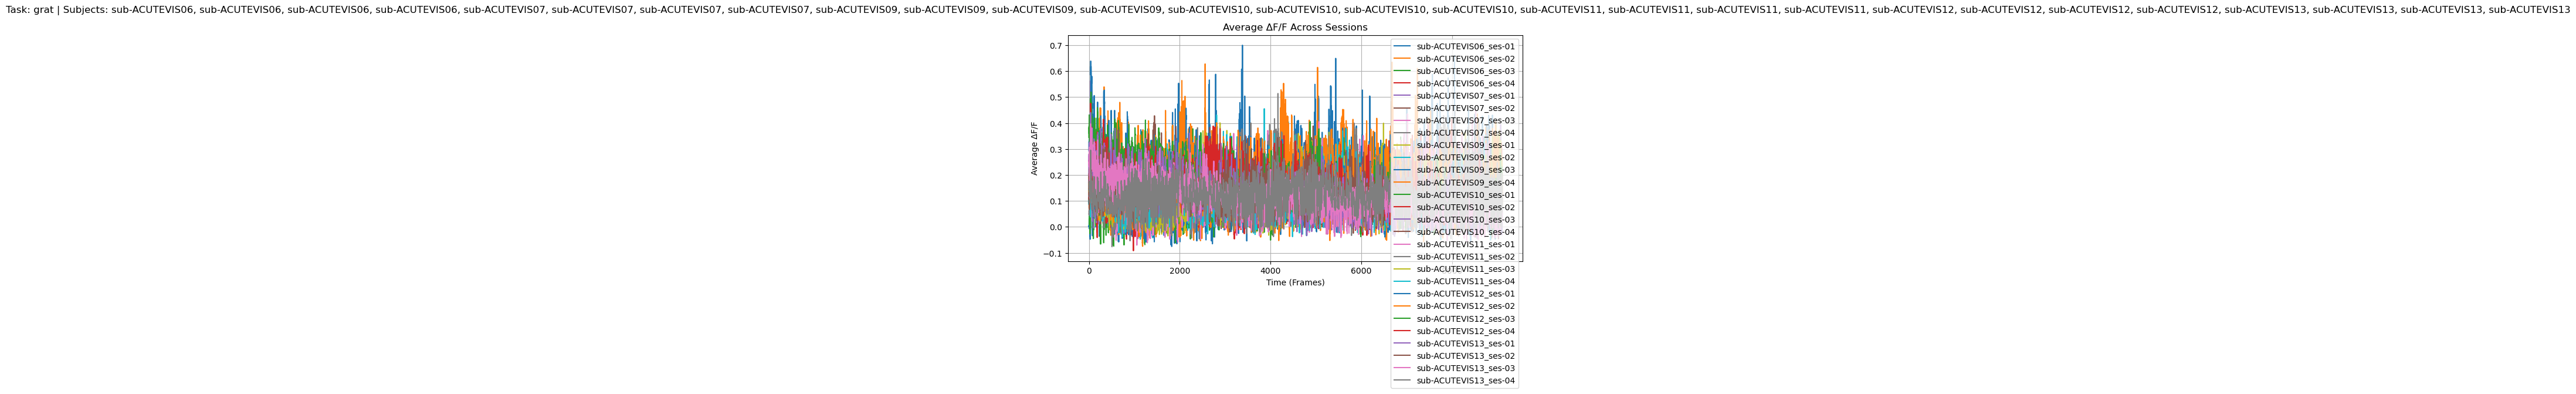

Frame-averaged ΔF/F per session:
                       Mean_Average_ROI
sub-ACUTEVIS06_ses-01          0.149214
sub-ACUTEVIS06_ses-02          0.149283
sub-ACUTEVIS06_ses-03          0.138699
sub-ACUTEVIS06_ses-04          0.133035
sub-ACUTEVIS07_ses-01          0.120927
sub-ACUTEVIS07_ses-02          0.142510
sub-ACUTEVIS07_ses-03          0.104275
sub-ACUTEVIS07_ses-04          0.115219
sub-ACUTEVIS09_ses-01          0.138691
sub-ACUTEVIS09_ses-02          0.124362
sub-ACUTEVIS09_ses-03          0.135653
sub-ACUTEVIS09_ses-04          0.135893
sub-ACUTEVIS10_ses-01          0.111887
sub-ACUTEVIS10_ses-02          0.116749
sub-ACUTEVIS10_ses-03          0.125689
sub-ACUTEVIS10_ses-04          0.120731
sub-ACUTEVIS11_ses-01          0.135978
sub-ACUTEVIS11_ses-02          0.130188
sub-ACUTEVIS11_ses-03          0.117553
sub-ACUTEVIS11_ses-04          0.128684
sub-ACUTEVIS12_ses-01          0.164856
sub-ACUTEVIS12_ses-02          0.165185
sub-ACUTEVIS12_ses-03          0.172657
sub-ACU

In [165]:
# %% CALCULATE & PLOT AVERAGE DFF PER SESSION

average_dff_by_session = pd.DataFrame({
    session_key: results['average_df']['Average_ROI'] for session_key, results in session_results.items()
}).sort_index(axis=1)

session_subjects = [session_metadata[key]['subject'] for key in average_dff_by_session.columns]
task_labels = sorted({session_metadata[key]['task'] for key in session_metadata})

plt.figure(figsize=(10, 5))
for session_key in average_dff_by_session.columns:
    plt.plot(average_dff_by_session.index, average_dff_by_session[session_key], label=session_key)
plt.suptitle(
    f"Task: {', '.join(task_labels)} | Subjects: {', '.join(sorted(session_metadata[key]['subject'] for key in session_metadata))}"
 )
plt.title("Average ΔF/F Across Sessions")
plt.xlabel("Time (Frames)")
plt.ylabel("Average ΔF/F")
plt.grid()
plt.legend()
plt.show()

session_mean_dff = average_dff_by_session.mean()
subject_mean_dff = session_mean_dff.groupby(session_subjects).mean()

print("Frame-averaged ΔF/F per session:")
print(session_mean_dff.to_frame(name='Mean_Average_ROI'))
print("\nSession means aggregated per subject:")
print(subject_mean_dff.to_frame(name='Subject_Mean_Average_ROI'))

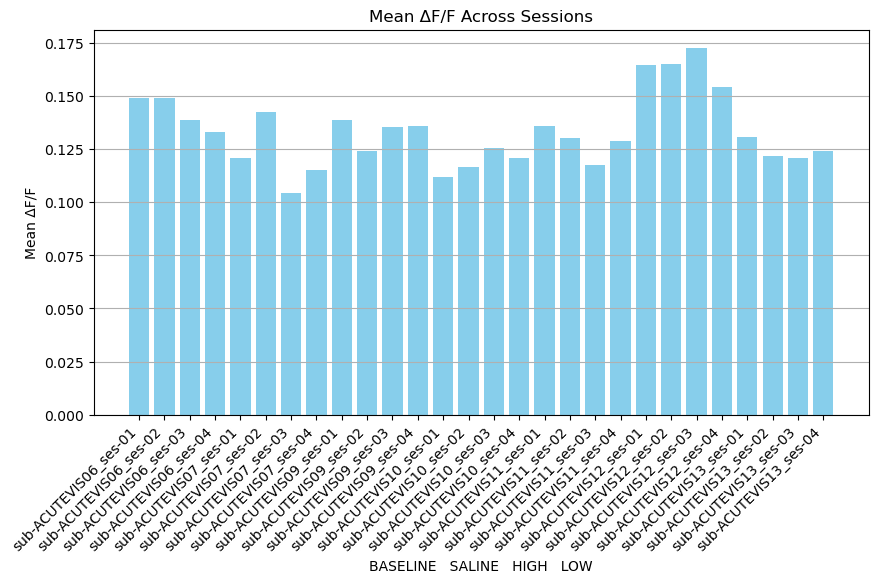

In [166]:
# Avg dff across sessions as a bar graph
plt.figure(figsize=(10, 5))
plt.bar(session_mean_dff.index, session_mean_dff.values, color='skyblue')
plt.title("Mean ΔF/F Across Sessions")
plt.xlabel("BASELINE   SALINE   HIGH   LOW")
plt.ylabel("Mean ΔF/F")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.show()

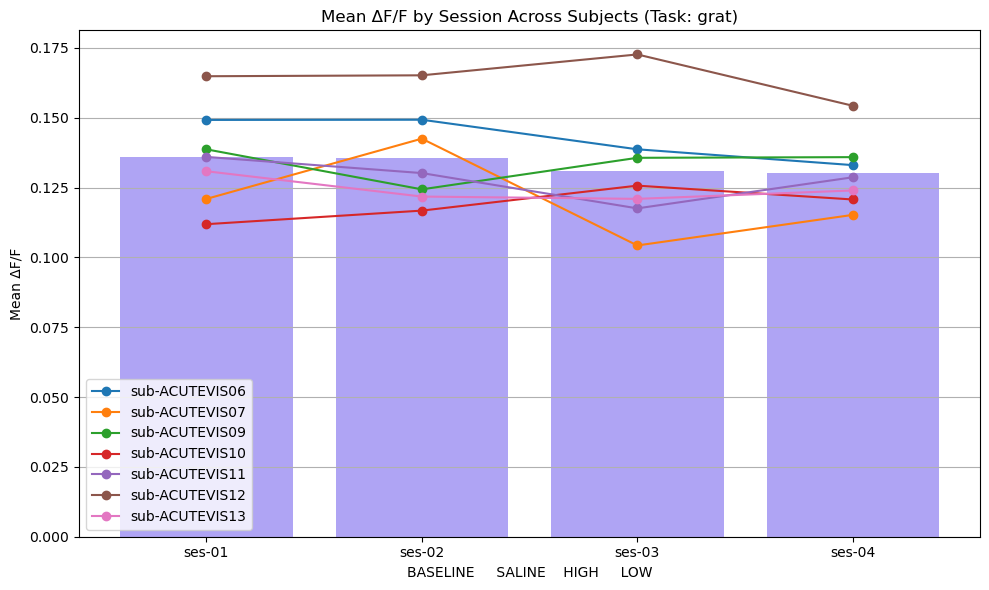

,session_label,mean_dff,sem_dff
0,ses-01,0.136057,0.006636
1,ses-02,0.135722,0.006569
2,ses-03,0.130783,0.008223
3,ses-04,0.130259,0.004820


In [167]:
# AVG DFF ACROSS SESSIONS FOR ALL SUBJECTS
session_mean_summary = session_mean_dff.rename("mean_dff").to_frame().reset_index().rename(columns={"index": "session_key"})
session_mean_summary[["subject", "session_label"]] = session_mean_summary["session_key"].str.split("_", n=1, expand=True)
session_mean_summary["task"] = session_mean_summary["session_key"].map(lambda key: session_metadata[key]["task"])
session_mean_summary["session_label"] = session_mean_summary["session_label"].apply(normalise_session_id)
session_order_map = {label: idx for idx, label in enumerate(sorted(session_mean_summary["session_label"].unique()))}
session_mean_summary["session_order"] = session_mean_summary["session_label"].map(session_order_map)
session_mean_summary = session_mean_summary.sort_values(["session_order", "subject"]).reset_index(drop=True)

session_avg_by_label = (
    session_mean_summary.groupby("session_label")["mean_dff"].agg(mean_dff="mean", sem_dff="sem").reset_index()
 )
session_avg_by_label["sem_dff"] = session_avg_by_label["sem_dff"].fillna(0)
task_labels = ", ".join(sorted(session_mean_summary["task"].unique()))

plt.figure(figsize=(10, 6))
plt.bar(
    session_avg_by_label["session_label"],
    session_avg_by_label["mean_dff"],
    # yerr=session_avg_by_label["sem_dff"],
    color="mediumslateblue",
    alpha=0.6,
    capsize=5,
    # label="Subject mean ± SEM"
 )
for subject, subject_df in session_mean_summary.groupby("subject"):
    subject_df = subject_df.sort_values("session_order")
    plt.plot(
        subject_df["session_label"],
        subject_df["mean_dff"],
        marker="o",
        label=subject
    )
plt.title(f"Mean ΔF/F by Session Across Subjects (Task: {task_labels})")
plt.xlabel("BASELINE     SALINE    HIGH     LOW")
plt.ylabel("Mean ΔF/F")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

session_avg_by_label

In [168]:
# DETECT PEAKS DURING EACH SESSION

def detect_roi_peaks(session_results, prominence=1.0, height=None, distance=None, width=None):
    """Run scipy.signal.find_peaks for every ROI in every session."""
    from scipy.signal import find_peaks
    peak_summary = {}
    peak_records = []
    optional_args = {}
    if height is not None:
        optional_args['height'] = height
    if distance is not None:
        optional_args['distance'] = distance
    if width is not None:
        optional_args['width'] = width
    for session_key, results in session_results.items():
        roi_traces = results['roi_dff']
        subject_label = results.get('subject', session_key.split('_', 1)[0])
        session_label = results.get('session_label', session_key.split('_', 1)[1])
        session_store = {}
        for roi_index, roi_trace in enumerate(roi_traces):
            roi_array = np.asarray(roi_trace, dtype=float).flatten()
            peaks, properties = find_peaks(roi_array, prominence=prominence, **optional_args)
            session_store[roi_index] = {'peaks': peaks, 'properties': properties}
            for peak_idx, frame_idx in enumerate(peaks):
                record = {
                    'subject': subject_label,
                    'session_label': session_label,
                    'session': session_key,
                    'roi_index': roi_index,
                    'peak_frame': int(frame_idx),
                    'peak_value': float(roi_array[frame_idx])
                }
                for prop_name, values in properties.items():
                    if isinstance(values, np.ndarray):
                        record[prop_name] = float(values[peak_idx])
                    else:
                        record[prop_name] = float(values)
                peak_records.append(record)
        peak_summary[session_key] = session_store
    peaks_df = pd.DataFrame(peak_records)
    return peak_summary, peaks_df

roi_peaks_by_session, roi_peak_df = detect_roi_peaks(session_results, prominence=0.7)
print(f"Peak DataFrame shape: {roi_peak_df.shape}")
roi_peak_df.head()

Peak DataFrame shape: (49280, 9)


,subject,session_label,session,roi_index,peak_frame,peak_value,prominences,left_bases,right_bases
0,sub-ACUTEVIS06,ses-01,sub-ACUTEVIS06_ses-01,0,285,0.868045,0.870454,250.0,482.0
1,sub-ACUTEVIS06,ses-01,sub-ACUTEVIS06_ses-01,0,584,0.973158,1.040567,482.0,2577.0
2,sub-ACUTEVIS06,ses-01,sub-ACUTEVIS06_ses-01,0,881,0.933621,1.057803,754.0,1157.0
3,sub-ACUTEVIS06,ses-01,sub-ACUTEVIS06_ses-01,0,1186,0.920281,1.040982,1157.0,1677.0
4,sub-ACUTEVIS06,ses-01,sub-ACUTEVIS06_ses-01,0,1473,0.868963,0.985301,1292.0,1677.0


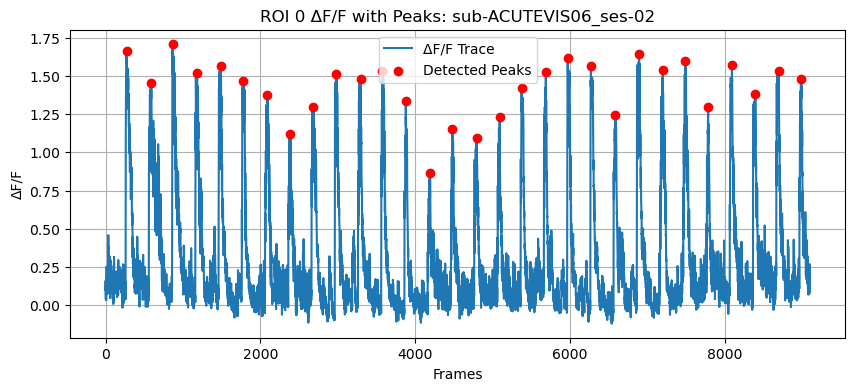

,subject,session_label,session,roi_index,peak_frame,peak_value,prominences,left_bases,right_bases
5287,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,272,1.663732,1.680191,219.0,820.0
5288,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,591,1.456046,1.467082,520.0,820.0
5289,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,867,1.711011,1.735671,820.0,6537.0
5290,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,1183,1.521881,1.543745,1138.0,1448.0
5291,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,1487,1.562872,1.590721,1448.0,4073.0
5292,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,1780,1.465641,1.546769,1665.0,2620.0
5293,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,2087,1.375142,1.445985,2019.0,2620.0
5294,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,2377,1.122066,1.184839,2279.0,2620.0
5295,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,2685,1.296162,1.401702,2620.0,2865.0
5296,sub-ACUTEVIS06,ses-02,sub-ACUTEVIS06_ses-02,0,2983,1.514115,1.589977,2620.0,3464.0


In [169]:
# VERIFY PEAKS ON A SAMPLE ROI

preview_roi_index = selected_roi_index
if selected_session_key not in roi_peaks_by_session:
    raise KeyError(f"Session {selected_session_key} not present in roi_peaks_by_session.")
if preview_roi_index not in roi_peaks_by_session[selected_session_key]:
    raise KeyError(f"ROI {preview_roi_index} not present in roi_peaks_by_session[{selected_session_key}].")

roi_trace = np.asarray(selected_results['roi_dff'][preview_roi_index], dtype=float).flatten()
peak_info = roi_peaks_by_session[selected_session_key][preview_roi_index]
peak_indices = peak_info['peaks']

plt.figure(figsize=(10, 4))
plt.plot(roi_trace, label='ΔF/F Trace')
if peak_indices.size:
    plt.scatter(peak_indices, roi_trace[peak_indices], color='red', label='Detected Peaks', zorder=3)
plt.title(f'ROI {preview_roi_index} ΔF/F with Peaks: {selected_session_key}')
plt.xlabel('Frames')
plt.ylabel('ΔF/F')
plt.legend()
plt.grid()
plt.show()

roi_peak_df[(roi_peak_df['session'] == selected_session_key) & (roi_peak_df['roi_index'] == preview_roi_index)]

Average number of peaks per session (with SEM):
    Average_Number_of_Peaks  SEM_Number_of_Peaks  \
0                 11.394397             0.446455   
1                 11.401544             0.714174   
2                  9.687831             0.789948   
3                  7.256303             0.560830   
4                  4.510870             0.241211   
5                  8.071633             0.408220   
6                  5.308271             0.410887   
7                  7.145763             0.647132   
8                 11.165289             1.095593   
9                  9.691489             2.421640   
10                 8.530303             1.179313   
11                 9.878378             2.133542   
12                10.051852             1.118532   
13                16.821782             3.400041   
14                16.156863             2.654685   
15                16.666667             2.976689   
16                13.377193             2.074396   
17              

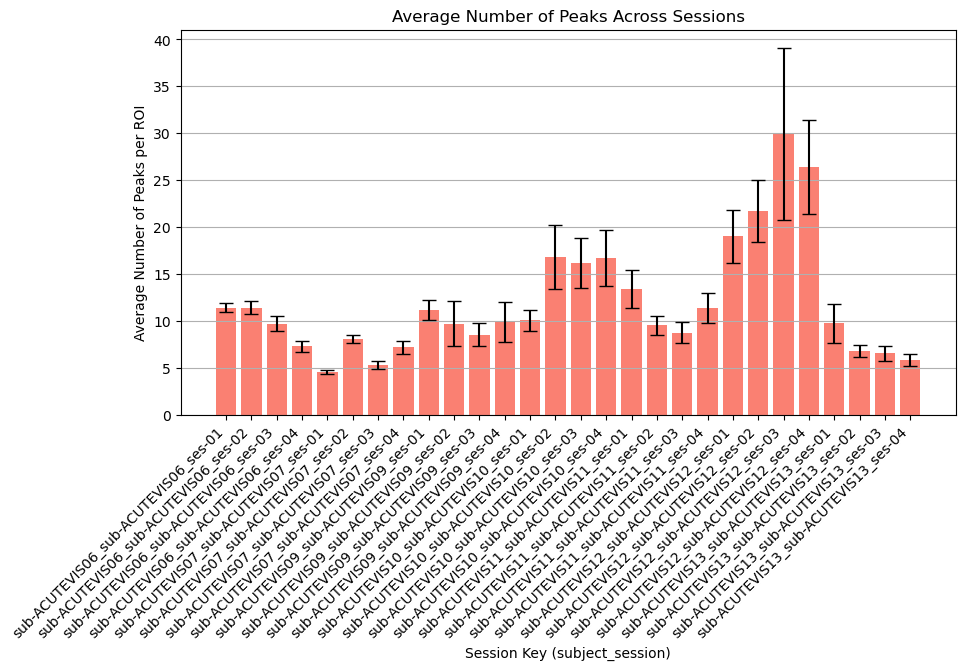

In [156]:
# AVG NUMBER OF PEAKS FOR ALL ROIS ACROSS SESSIONS
if roi_peak_df.empty:
    print("No peaks detected; consider lowering the prominence threshold.")
else:
    peaks_per_roi = (
        roi_peak_df.groupby(['subject', 'session', 'roi_index'])
        .size()
        .reset_index(name='peak_count')
    )
    avg_num_peaks_by_session = peaks_per_roi.groupby(['subject', 'session'])['peak_count'].mean()
    sem_num_peaks_by_session = peaks_per_roi.groupby(['subject', 'session'])['peak_count'].sem().fillna(0)
    summary_df = pd.DataFrame({
        'Average_Number_of_Peaks': avg_num_peaks_by_session,
        'SEM_Number_of_Peaks': sem_num_peaks_by_session
    })
    summary_df['session_key'] = [f"{idx[0]}_{idx[1]}" for idx in summary_df.index]
    print("Average number of peaks per session (with SEM):")
    print(summary_df.reset_index(drop=True))

    # PLOT AVG NUMBER OF PEAKS ACROSS SESSIONS
    plt.figure(figsize=(10, 5))
    plt.bar(
        summary_df['session_key'],
        summary_df['Average_Number_of_Peaks'],
        yerr=summary_df['SEM_Number_of_Peaks'],
        color='salmon',
        capsize=5
    )
    plt.title("Average Number of Peaks Across Sessions")
    plt.xlabel("Session Key (subject_session)")
    plt.ylabel("Average Number of Peaks per ROI")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.show()

Session-level mean peaks per ROI (mean ± SEM across subjects):
  session_label  mean_peaks  sem_peaks
0        ses-01   11.318257   1.642476
1        ses-02   11.995321   2.024481
2        ses-03   12.110465   3.237591
3        ses-04   12.081106   2.750382


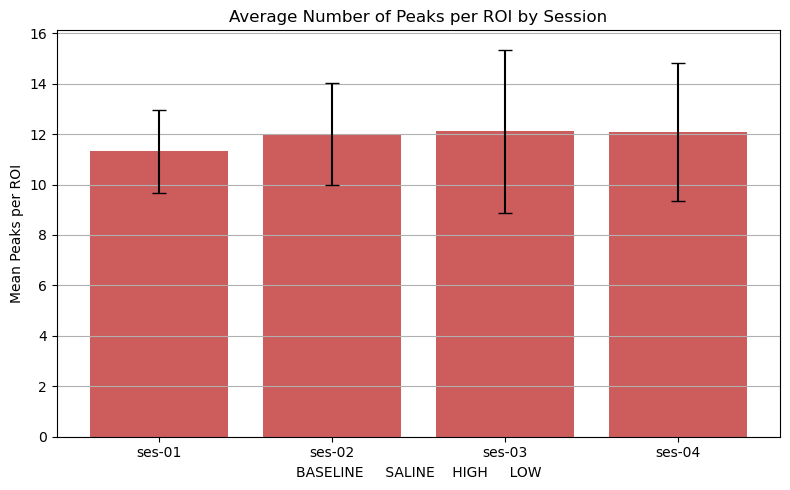

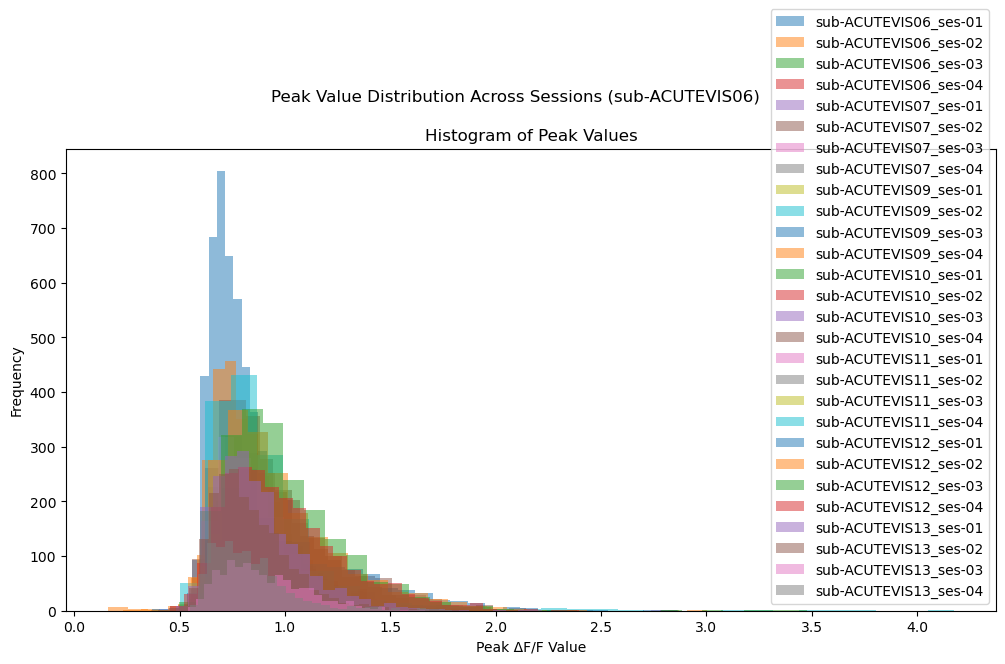

In [160]:
# NEW FUNCTION HERE
def plot_avg_peaks_per_session(roi_peak_df):
    """Aggregate peak counts across subjects and plot session-level means."""
    if roi_peak_df.empty:
        raise ValueError("roi_peak_df is empty; run the peak detection step first.")

    peaks_per_roi = (
        roi_peak_df.groupby(['subject', 'session', 'roi_index'])
        .size()
        .reset_index(name='peak_count')
    )

    subject_session_means = (
        peaks_per_roi.groupby(['subject', 'session'])['peak_count']
        .mean()
        .reset_index(name='avg_peaks_per_roi')
    )
    if subject_session_means.empty:
        raise ValueError("No peak counts available after aggregation; check prominence threshold.")

    def _session_label_from_value(value):
        value_str = str(value)
        extracted = value_str.split('_', 1)[1] if '_' in value_str else value_str
        return normalise_session_id(extracted)

    subject_session_means['session_label'] = subject_session_means['session'].map(_session_label_from_value)
    order_map = {label: idx for idx, label in enumerate(sorted(subject_session_means['session_label'].unique()))}
    subject_session_means['session_order'] = subject_session_means['session_label'].map(order_map)
    session_summary = (
        subject_session_means.groupby('session_label')['avg_peaks_per_roi']
        .agg(mean_peaks='mean', sem_peaks='sem')
        .reset_index()
        .sort_values('session_label', key=lambda s: s.map(order_map))
    )
    session_summary['sem_peaks'] = session_summary['sem_peaks'].fillna(0)

    print("Session-level mean peaks per ROI (mean ± SEM across subjects):")
    print(session_summary)

    plt.figure(figsize=(8, 5))
    plt.bar(
        session_summary['session_label'],
        session_summary['mean_peaks'],
        yerr=session_summary['sem_peaks'],
        color='indianred',
        capsize=5
    )
    plt.title("Average Number of Peaks per ROI by Session")
    plt.xlabel("BASELINE     SALINE    HIGH     LOW")
    plt.ylabel("Mean Peaks per ROI")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return session_summary


if 'roi_peak_df' not in globals():
    raise NameError("roi_peak_df not found; run the peak detection cell first.")
plot_avg_peaks_per_session(roi_peak_df)
plt.figure(figsize=(12, 6))
for session_key in average_dff_by_session.columns:
    session_peaks = roi_peak_df[roi_peak_df['session'] == session_key]
    plt.hist(session_peaks['peak_value'], bins=30, alpha=0.5, label=session_key)
plt.suptitle(f"Peak Value Distribution Across Sessions ({subject_label})")
plt.title("Histogram of Peak Values")
plt.xlabel("Peak ΔF/F Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


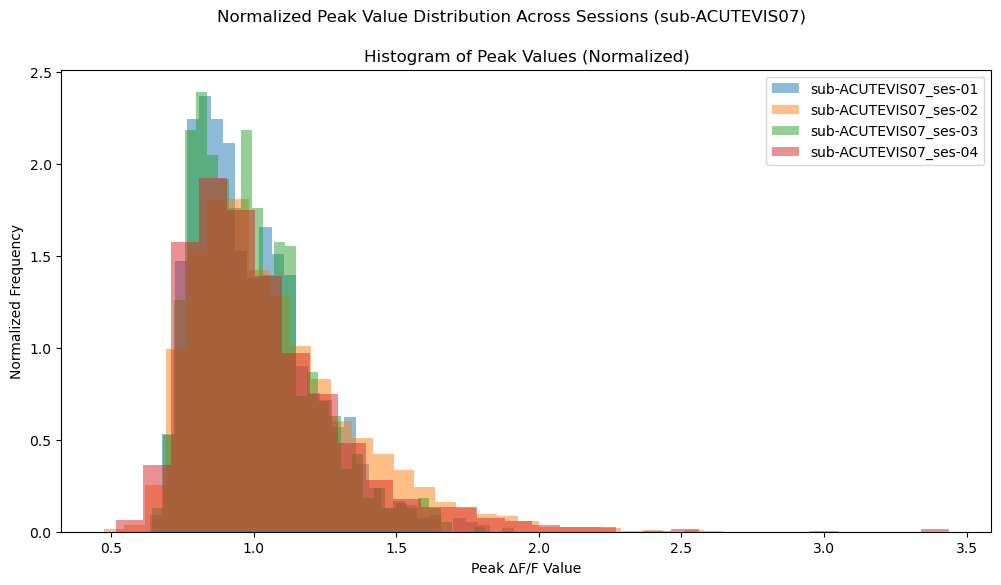